<a href="https://colab.research.google.com/github/vijaygwu/robotics/blob/main/SyntheticCells_Neuromorphic_StateMachine_Moderate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Cells as Neuromorphic State Machines  

**Topic:** Synthetic Cells (Colloidal State Machines), Memristors, Hybrid Control, Edge AI

## Learning goals
By the end of this notebook, you will be able to:
1. Simulate a **memristor** as a simple nonlinear dynamical system (stateful resistor)
2. Implement the **SynCell AND logic** (Light ∧ Chemical → memory write)
3. Compare **hardware thresholding** vs a tiny **AI classifier**
4. Compute a simple **energy budget** for switching / inference
5. Simulate a **swarm** of SynCells mapping an environment

> This notebook is self-contained: it generates synthetic data and figures automatically.


In [13]:

# Imports (keep it lightweight)
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(7)

def sigmoid(z):
    return 1/(1+np.exp(-z))

print("✅ Imports loaded. Random seed set to 7.")


✅ Imports loaded. Random seed set to 7.


---
## 1) Memristor model (stateful resistor)

We’ll use a **moderate** toy model that captures the key idea:
- A memristor has an internal state variable **w(t)** (bounded in [0,1])
- Resistance depends on that state:
\[ R(w) = R_{ON} \cdot w + R_{OFF} \cdot (1-w) \]
- The state evolves based on applied voltage (or current). We use a *thresholded* drift model:
\[ \dot{w} = \alpha \cdot \max(0, |V|-V_{th}) \cdot \text{sign}(V) - \beta (w- w_0) \]
Intuition:
- If |V| is below threshold, state barely moves
- If |V| exceeds threshold, state shifts (writing)
- A small “leak” term pulls w back toward a baseline **w0**

This is not the only model, but it’s enough to reason about **state, transitions, and energy**.


In [14]:

def memristor_step(w, V, dt, params):
    """One Euler step for a thresholded memristor state model."""
    alpha = params['alpha']
    beta  = params['beta']
    Vth   = params['Vth']
    w0    = params['w0']

    drive = max(0.0, abs(V) - Vth)
    dw = alpha * drive * np.sign(V) - beta*(w - w0)
    w_new = w + dt*dw
    w_new = min(1.0, max(0.0, w_new))  # clamp to [0,1]
    return w_new

def R_of_w(w, Ron, Roff):
    return Ron*w + Roff*(1-w)

m_params = dict(alpha=3.0, beta=0.15, Vth=0.18, w0=0.15)
Ron, Roff = 2e4, 2e6   # 20 kΩ ON, 2 MΩ OFF
dt = 1e-3              # 1 ms step

print("✅ Memristor model defined.")
print("Params:", m_params, "Ron=", Ron, "Roff=", Roff, "dt=", dt)


✅ Memristor model defined.
Params: {'alpha': 3.0, 'beta': 0.15, 'Vth': 0.18, 'w0': 0.15} Ron= 20000.0 Roff= 2000000.0 dt= 0.001


### 1.1 Simulate a voltage sweep (hysteresis-style)

We’ll apply a triangular waveform and compute I = V / R(w).  
You should see **history-dependent behavior** (a crude hysteresis).


Diagnostics:
  w min/max: 0.10949332849297001 0.4432023447640634
  R min/max (Ohm): 1122459.3573671544 1783203.2095839195
  I min/max (A): -3.3791902063659554e-07 3.5644775323426776e-07


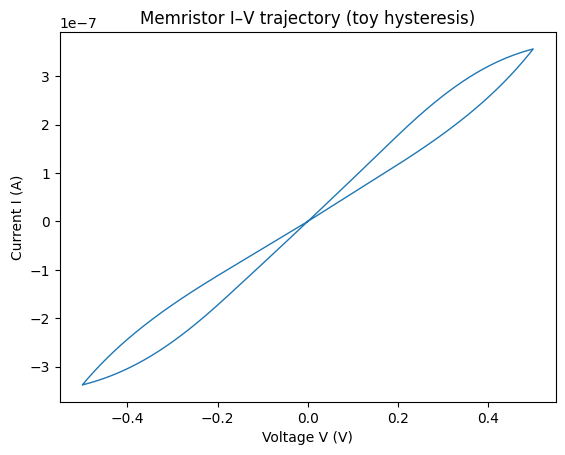

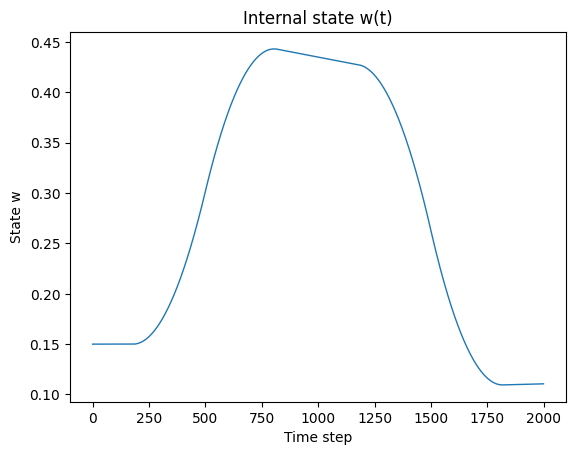

In [15]:

def triangular_wave(num_steps, Vmax):
    q = num_steps // 4
    seg1 = np.linspace(0, Vmax, q, endpoint=False)
    seg2 = np.linspace(Vmax, 0, q, endpoint=False)
    seg3 = np.linspace(0, -Vmax, q, endpoint=False)
    seg4 = np.linspace(-Vmax, 0, num_steps - 3*q)
    return np.concatenate([seg1, seg2, seg3, seg4])

num_steps = 2000
Vmax = 0.5
Vs = triangular_wave(num_steps, Vmax)

w = 0.15
ws, Rs, Is = [], [], []
for V in Vs:
    w = memristor_step(w, V, dt, m_params)
    R = R_of_w(w, Ron, Roff)
    I = V / R
    ws.append(w); Rs.append(R); Is.append(I)

ws = np.array(ws); Rs = np.array(Rs); Is = np.array(Is)

print("Diagnostics:")
print("  w min/max:", ws.min(), ws.max())
print("  R min/max (Ohm):", Rs.min(), Rs.max())
print("  I min/max (A):", Is.min(), Is.max())

plt.figure()
plt.plot(Vs, Is, linewidth=1)
plt.xlabel("Voltage V (V)")
plt.ylabel("Current I (A)")
plt.title("Memristor I–V trajectory (toy hysteresis)")
plt.show()

plt.figure()
plt.plot(ws, linewidth=1)
plt.xlabel("Time step")
plt.ylabel("State w")
plt.title("Internal state w(t)")
plt.show()


---
## 2) SynCell AND logic: Light ∧ Chemical → write memory

We’ll model:
- Light intensity L ∈ [0,1]
- Chemical concentration C ∈ [0,1]
- Photodiode voltage: \[ V_{ph} = k_L \cdot L \]
- Chemiresistor resistance: \[ R_{ch}(C) = \frac{1}{G_0 + \gamma C} \]
- Voltage divider (toy):  
\[ V_{mem} = V_{ph} \cdot \frac{R_{mem}}{R_{mem}+R_{ch}} \]

We “write” if |Vmem| exceeds Vth long enough.


In [16]:

kL = 0.45         # photodiode gain
G0 = 2e-8         # baseline conductance (S)
gamma = 9e-8      # analyte sensitivity (S per unit chemical)

def R_ch_of_C(C):
    return 1.0 / (G0 + gamma*C)

def simulate_synCell_write(L, C, steps=200, dt=1e-3):
    Vph = kL * L
    w = 0.15
    for _ in range(steps):
        Rmem = R_of_w(w, Ron, Roff)
        Rch = R_ch_of_C(C)
        Vmem = Vph * (Rmem/(Rmem + Rch))
        w = memristor_step(w, Vmem, dt, m_params)
    return (w > 0.6), w

for L, C in [(0.2,0.2), (0.9,0.2), (0.2,0.9), (0.9,0.9)]:
    on, w_final = simulate_synCell_write(L, C)
    print(f"L={L:.1f}, C={C:.1f} -> ON={on}, final w={w_final:.3f}")


L=0.2, C=0.2 -> ON=False, final w=0.150
L=0.9, C=0.2 -> ON=False, final w=0.150
L=0.2, C=0.9 -> ON=False, final w=0.150
L=0.9, C=0.9 -> ON=False, final w=0.150


### 2.1 Decision boundary plot

Sweep (L,C) and plot where the SynCell writes memory.


ON fraction: 0.0


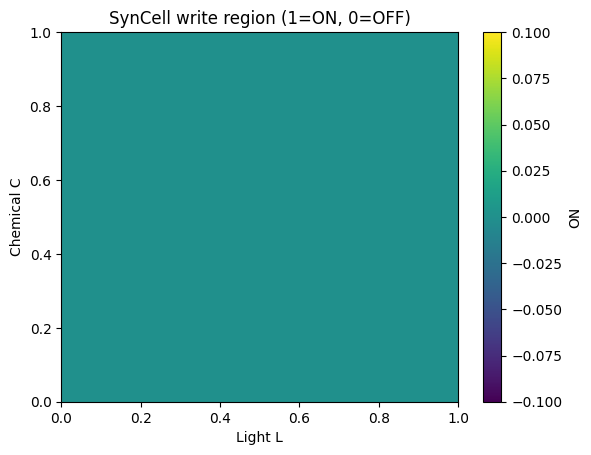

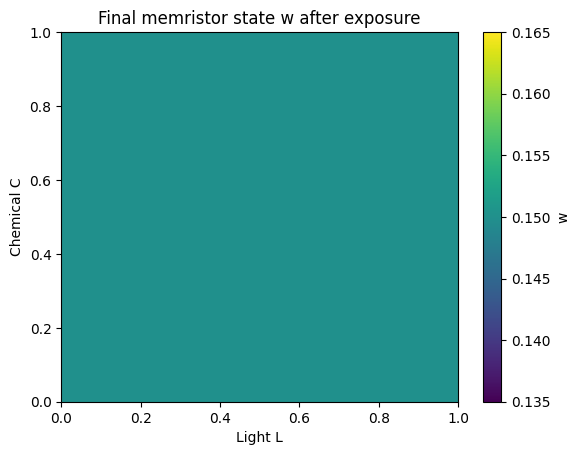

In [17]:

grid = 60
Ls = np.linspace(0,1,grid)
Cs = np.linspace(0,1,grid)

ON = np.zeros((grid, grid), dtype=int)
Wf = np.zeros((grid, grid), dtype=float)

for i, L in enumerate(Ls):
    for j, C in enumerate(Cs):
        on, w_final = simulate_synCell_write(L, C)
        ON[j,i] = 1 if on else 0
        Wf[j,i] = w_final

print("ON fraction:", ON.mean())

plt.figure()
plt.imshow(ON, origin="lower", extent=[0,1,0,1], aspect="auto")
plt.xlabel("Light L")
plt.ylabel("Chemical C")
plt.title("SynCell write region (1=ON, 0=OFF)")
plt.colorbar(label="ON")
plt.show()

plt.figure()
plt.imshow(Wf, origin="lower", extent=[0,1,0,1], aspect="auto")
plt.xlabel("Light L")
plt.ylabel("Chemical C")
plt.title("Final memristor state w after exposure")
plt.colorbar(label="w")
plt.show()


---
## 3) “AI layer”: a tiny classifier vs hardware thresholding

We generate labeled data from the physical SynCell model and train **logistic regression** (from scratch):
\[ \hat{y} = \sigma(\theta_0 + \theta_1 L + \theta_2 C) \]

Interpretation:
- Hardware: physics performs inference
- AI: learns the boundary from data


In [18]:

N = 2000
L_data = np.random.rand(N)
C_data = np.random.rand(N)

y = np.zeros(N, dtype=int)
w_final = np.zeros(N)

for n in range(N):
    on, wf = simulate_synCell_write(L_data[n], C_data[n])
    y[n] = 1 if on else 0
    w_final[n] = wf

X = np.stack([np.ones(N), L_data, C_data], axis=1)

print("Dataset created.")
print("  Positive class rate:", y.mean())
print("  X shape:", X.shape)


Dataset created.
  Positive class rate: 0.0
  X shape: (2000, 3)


epoch    0 | loss=0.6931 | theta=[-0.5        -0.24662148 -0.2492921 ]
epoch    1 | loss=0.3893 | theta=[-0.82211317 -0.40088829 -0.40530633]
epoch    2 | loss=0.2607 | theta=[-1.05102751 -0.50775826 -0.5134259 ]
epoch    5 | loss=0.1283 | theta=[-1.48976314 -0.70594637 -0.71400033]
epoch   10 | loss=0.0693 | theta=[-1.904845   -0.88574342 -0.89600913]
epoch   50 | loss=0.0150 | theta=[-3.02407239 -1.33789705 -1.35369623]
epoch  100 | loss=0.0077 | theta=[-3.54288739 -1.53351539 -1.5516109 ]
epoch  300 | loss=0.0026 | theta=[-4.39175234 -1.83726891 -1.85871713]
epoch  600 | loss=0.0013 | theta=[-4.94068288 -2.02400409 -2.04734936]
epoch 1199 | loss=0.0007 | theta=[-5.49783501 -2.20649958 -2.23155555]


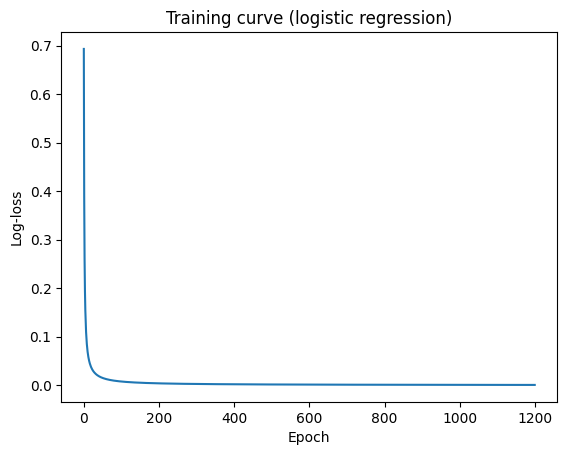

Final accuracy: 1.0


In [19]:

theta = np.zeros(3)
lr = 1.0
epochs = 1200

def loss_and_grad(theta, X, y):
    z = X @ theta
    p = sigmoid(z)
    eps = 1e-12
    loss = -(y*np.log(p+eps) + (1-y)*np.log(1-p+eps)).mean()
    grad = (X.T @ (p - y)) / len(y)
    return loss, grad

loss_hist = []
for ep in range(epochs):
    loss, grad = loss_and_grad(theta, X, y)
    theta -= lr*grad
    loss_hist.append(loss)
    if ep in [0,1,2,5,10,50,100,300,600,1199]:
        print(f"epoch {ep:4d} | loss={loss:.4f} | theta={theta}")

plt.figure()
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Log-loss")
plt.title("Training curve (logistic regression)")
plt.show()

p = sigmoid(X @ theta)
yhat = (p >= 0.5).astype(int)
acc = (yhat == y).mean()
print("Final accuracy:", acc)


### 3.1 Visualize learned decision boundary

Overlay the AI boundary on the physical ON/OFF map.


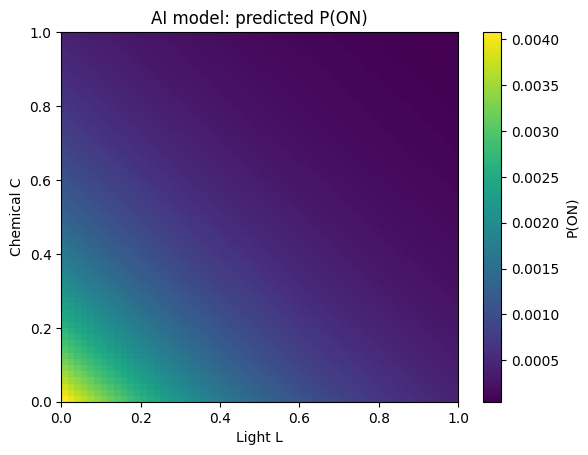

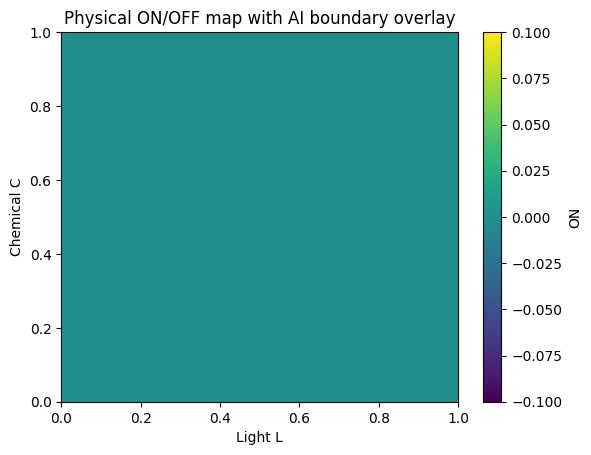

Theta: [-5.49783501 -2.20649958 -2.23155555]


In [20]:

P_grid = np.zeros((grid, grid))
for i, L in enumerate(Ls):
    for j, C in enumerate(Cs):
        x = np.array([1.0, L, C])
        P_grid[j,i] = sigmoid(x @ theta)

plt.figure()
plt.imshow(P_grid, origin="lower", extent=[0,1,0,1], aspect="auto")
plt.xlabel("Light L")
plt.ylabel("Chemical C")
plt.title("AI model: predicted P(ON)")
plt.colorbar(label="P(ON)")
plt.show()

Ls_line = np.linspace(0,1,200)
Cs_line = -(theta[0] + theta[1]*Ls_line)/theta[2] if abs(theta[2]) > 1e-9 else np.nan*Ls_line

plt.figure()
plt.imshow(ON, origin="lower", extent=[0,1,0,1], aspect="auto")
plt.plot(Ls_line, Cs_line, linewidth=2)
plt.ylim(0,1); plt.xlim(0,1)
plt.xlabel("Light L")
plt.ylabel("Chemical C")
plt.title("Physical ON/OFF map with AI boundary overlay")
plt.colorbar(label="ON")
plt.show()

print("Theta:", theta)


---
## 4) Energy-aware computation: switching cost vs “inference” cost

We estimate hardware energy:
\[ E \approx \sum_t |V_{mem}(t) \cdot I_{mem}(t)| \, dt \]
with \(I_{mem}=V_{mem}/R_{mem}(w)\).

Then compare to a toy digital inference energy (order-of-magnitude placeholder).


In [21]:

def synCell_energy(L, C, steps=200, dt=1e-3):
    Vph = kL * L
    w = 0.15
    E = 0.0
    for _ in range(steps):
        Rmem = R_of_w(w, Ron, Roff)
        Rch = R_ch_of_C(C)
        Vmem = Vph * (Rmem/(Rmem + Rch))
        Imem = Vmem / Rmem
        E += abs(Vmem * Imem) * dt
        w = memristor_step(w, Vmem, dt, m_params)
    return E, w

samples = [(0.9,0.9),(0.9,0.2),(0.2,0.9),(0.2,0.2)]
for L,C in samples:
    E, w = synCell_energy(L,C)
    print(f"L={L:.1f}, C={C:.1f} -> E≈{E:.3e} J, final w={w:.3f}")


L=0.9, C=0.9 -> E≈4.149e-10 J, final w=0.150
L=0.9, C=0.2 -> E≈7.116e-11 J, final w=0.150
L=0.2, C=0.9 -> E≈2.049e-11 J, final w=0.150
L=0.2, C=0.2 -> E≈3.514e-12 J, final w=0.150


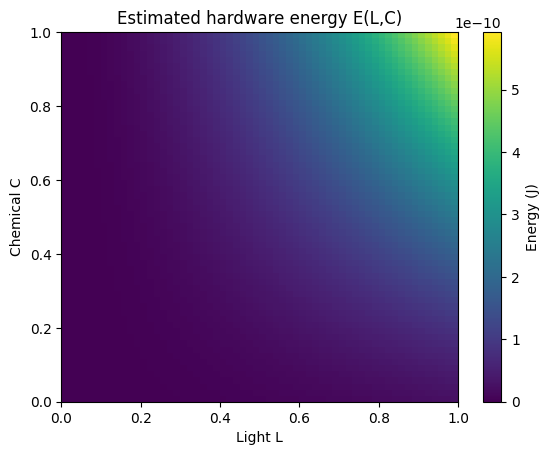

Mean energy when OFF: 8.777141263054052e-11
Mean energy when ON : nan


/tmp/ipython-input-3807914209.py:16: RuntimeWarning: Mean of empty slice.
  print("Mean energy when ON :", E_map[ON==1].mean())


In [22]:

E_map = np.zeros((grid, grid))
for i, L in enumerate(Ls):
    for j, C in enumerate(Cs):
        E, wf = synCell_energy(L, C)
        E_map[j,i] = E

plt.figure()
plt.imshow(E_map, origin="lower", extent=[0,1,0,1], aspect="auto")
plt.xlabel("Light L")
plt.ylabel("Chemical C")
plt.title("Estimated hardware energy E(L,C)")
plt.colorbar(label="Energy (J)")
plt.show()

print("Mean energy when OFF:", E_map[ON==0].mean())
print("Mean energy when ON :", E_map[ON==1].mean())


In [23]:

E_MAC = 1e-12  # toy: 1 pJ per multiply-add (placeholder)
E_digital = 5 * E_MAC

print("Toy digital inference energy per sample:", E_digital, "J")

for L,C in samples:
    E_hw, w = synCell_energy(L,C)
    ratio = E_hw / E_digital
    print(f"L={L:.1f}, C={C:.1f}: E_hw={E_hw:.2e} J, E_digital={E_digital:.2e} J, ratio={ratio:.1e}x")


Toy digital inference energy per sample: 5e-12 J
L=0.9, C=0.9: E_hw=4.15e-10 J, E_digital=5.00e-12 J, ratio=8.3e+01x
L=0.9, C=0.2: E_hw=7.12e-11 J, E_digital=5.00e-12 J, ratio=1.4e+01x
L=0.2, C=0.9: E_hw=2.05e-11 J, E_digital=5.00e-12 J, ratio=4.1e+00x
L=0.2, C=0.2: E_hw=3.51e-12 J, E_digital=5.00e-12 J, ratio=7.0e-01x


---
## 5) Swarm simulation (distributed mapping)

We simulate a 2D chemical plume, drop N SynCells randomly, and let each cell decide ON/OFF locally.
Then we visualize ON/OFF points over the field.


Swarm ON rate: 0.0


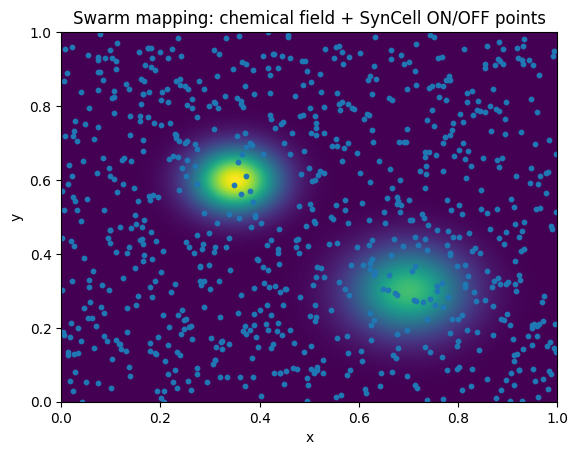

In [24]:

def chemical_field(x, y):
    c1 = np.exp(-((x-0.35)**2 + (y-0.6)**2)/(2*0.06**2))
    c2 = 0.7*np.exp(-((x-0.7)**2 + (y-0.3)**2)/(2*0.08**2))
    return np.clip(c1 + c2, 0, 1)

def light_field(x, y):
    return np.clip(0.6 + 0.4*x, 0, 1)

Nswarm = 800
xs = np.random.rand(Nswarm)
ys = np.random.rand(Nswarm)

Cs_local = np.array([chemical_field(x,y) for x,y in zip(xs,ys)])
Ls_local = np.array([light_field(x,y) for x,y in zip(xs,ys)])

on_flags = np.zeros(Nswarm, dtype=int)
for i in range(Nswarm):
    on, wf = simulate_synCell_write(Ls_local[i], Cs_local[i])
    on_flags[i] = 1 if on else 0

print("Swarm ON rate:", on_flags.mean())

res = 200
xx = np.linspace(0,1,res)
yy = np.linspace(0,1,res)
C_bg = np.zeros((res,res))
for i, y in enumerate(yy):
    for j, x in enumerate(xx):
        C_bg[i,j] = chemical_field(x,y)

plt.figure()
plt.imshow(C_bg, origin="lower", extent=[0,1,0,1], aspect="auto")
plt.scatter(xs[on_flags==0], ys[on_flags==0], s=10)
plt.scatter(xs[on_flags==1], ys[on_flags==1], s=12)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Swarm mapping: chemical field + SynCell ON/OFF points")
plt.show()


---
## 6) Short questions (submit answers)

1. Which parameter(s) most strongly controls the AND boundary: **kL**, **gamma**, or **Vth**? Why?  
2. In your energy plots, where is energy “wasted” (high energy but OFF)? Interpret physically.  
3. Logistic regression learned a linear boundary. The physical boundary can be nonlinear. What caused nonlinearity?  
4. If you were designing a *next-gen SynCell*, what would you change to improve: energy efficiency, memory reliability, AI capability?  


